In [1]:
import torch
import torch.nn as nn
from torch import optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images
from easyfsl.utils import sliding_average
from easyfsl.utils import evaluate
from easyfsl.datasets import WrapFewShotDataset
from torchvision.models import resnet18
from tqdm import tqdm

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit ResNet-18 input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

dataset = ImageFolder(
    root='data2',
    transform=transform
)

In [3]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)

c:\Users\Glen\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [4]:
len(train_dataset), len(test_dataset)

(752, 188)

In [5]:
class PrototypicalNetwork(nn.Module):
    def __init__(self, encoding_function):
        super(PrototypicalNetwork, self).__init__()
        self.encoding_function = encoding_function
        
    def forward(self, support_data, support_labels, query_data):
        # Getting embeddings for support and query set by forward propagating through pre-trained RestNet model
        support_data_ = self.encoding_function.forward(support_data)
        query_data_ = self.encoding_function.forward(query_data)
        
        
        # No. of classes
        n_way = len(torch.unique(support_labels))
        
        # Computing class prototypes (mean of all instances to their corresponding label)
        class_prototypes = torch.cat(
            [
                support_data_[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )
        
        # one_hot_labels = nn.functional.one_hot(support_labels, num_classes=n_way)
        
        # indices = torch.nonzero(one_hot_labels, as_tuple=True)
        
        # # Initialize tensor to hold the prototypes
        # class_prototypes = torch.zeros(n_way, support_data_.size(1))

        # for i in range(n_way):
        #     # Embeddings of the current class
        #     class_embeddings = support_data_[one_hot_labels[indices] == i]
        #     # Compute the mean of the embeddings to get the prototype
        #     class_prototypes[i] = class_embeddings.mean(dim=0)
            
        # Computing the euclidian distance between queries and class prototypes
        distances = torch.cdist(query_data_, class_prototypes)
        
        # Using softmax to transform distances to classification scores
        logits = -distances
        # classification_scores = logits.softmax(dim=1)
        
        return logits
    
encoding_function = resnet18(pretrained=True)
encoding_function.fc = nn.Flatten()

few_shot_classifier = PrototypicalNetwork(encoding_function)

c:\Users\Glen\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Glen\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
N_WAY = 2  # Number of classes in a task
N_SHOT = 4  # Number of images per class in the support set
N_QUERY = 8  # Number of images per class in the query set

N_EVALUATION_TASKS = 100
N_TRAINING_EPISODES = 400
N_VALIDATION_TASKS = 100

test_dataset_ = WrapFewShotDataset(test_dataset)

test_dataset_.get_labels = lambda: [
    instance[1] for instance in test_dataset
]

test_sampler = TaskSampler(
    test_dataset_, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_dataset_,
    batch_sampler=test_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

train_dataset_ = WrapFewShotDataset(train_dataset)

train_dataset_.get_labels = lambda: [instance[1] for instance in test_dataset]

train_sampler = TaskSampler(
    train_dataset_, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

train_loader = DataLoader(
    train_dataset_,
    batch_sampler=train_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

Scrolling dataset's labels...: 100%|██████████| 752/752 [00:00<?, ?it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


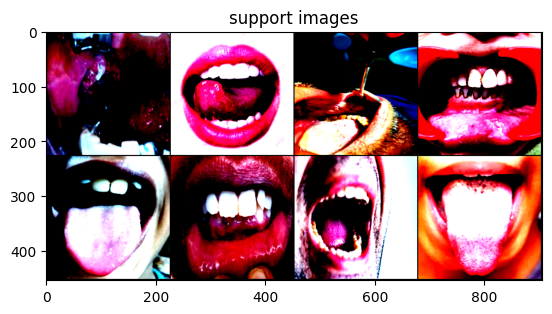

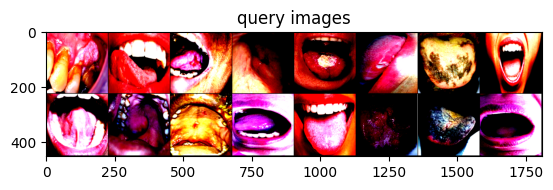

In [7]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(train_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(few_shot_classifier.parameters(), lr=0.001)

def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = few_shot_classifier(
        support_images, support_labels, query_images
    )

    print(classification_scores.shape, query_labels.shape)
    loss = criterion(classification_scores, query_labels)
    loss.backward()
    optimizer.step()

    return loss.item()

In [9]:
# Train the model yourself with this cell

log_update_frequency = 5

all_loss = []
few_shot_classifier.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

  0%|          | 0/400 [00:00<?, ?it/s]

torch.Size([16, 2]) torch.Size([16])


  0%|          | 1/400 [00:01<08:54,  1.34s/it, loss=1.21]

torch.Size([16, 2]) torch.Size([16])


  0%|          | 2/400 [00:02<08:03,  1.22s/it, loss=1.21]

torch.Size([16, 2]) torch.Size([16])


  1%|          | 3/400 [00:03<07:41,  1.16s/it, loss=1.21]

torch.Size([16, 2]) torch.Size([16])


  1%|          | 4/400 [00:04<07:31,  1.14s/it, loss=1.21]

torch.Size([16, 2]) torch.Size([16])


  1%|▏         | 5/400 [00:05<07:28,  1.14s/it, loss=1.21]

torch.Size([16, 2]) torch.Size([16])


  2%|▏         | 6/400 [00:06<07:25,  1.13s/it, loss=1.04]

torch.Size([16, 2]) torch.Size([16])


  2%|▏         | 7/400 [00:08<07:19,  1.12s/it, loss=1.04]

torch.Size([16, 2]) torch.Size([16])


  2%|▏         | 8/400 [00:09<07:16,  1.11s/it, loss=1.04]

torch.Size([16, 2]) torch.Size([16])


  2%|▏         | 9/400 [00:10<07:12,  1.11s/it, loss=1.04]

torch.Size([16, 2]) torch.Size([16])


  2%|▎         | 10/400 [00:11<07:11,  1.11s/it, loss=1.04]

torch.Size([16, 2]) torch.Size([16])


  3%|▎         | 11/400 [00:12<07:08,  1.10s/it, loss=1.49]

torch.Size([16, 2]) torch.Size([16])


  3%|▎         | 12/400 [00:13<07:22,  1.14s/it, loss=1.49]

torch.Size([16, 2]) torch.Size([16])


  3%|▎         | 13/400 [00:14<07:20,  1.14s/it, loss=1.49]

torch.Size([16, 2]) torch.Size([16])


  4%|▎         | 14/400 [00:15<07:17,  1.13s/it, loss=1.49]

torch.Size([16, 2]) torch.Size([16])


  4%|▍         | 15/400 [00:16<07:12,  1.12s/it, loss=1.49]

torch.Size([16, 2]) torch.Size([16])


  4%|▍         | 16/400 [00:18<07:11,  1.12s/it, loss=2.04]

torch.Size([16, 2]) torch.Size([16])


  4%|▍         | 17/400 [00:19<07:18,  1.14s/it, loss=2.04]

torch.Size([16, 2]) torch.Size([16])


  4%|▍         | 18/400 [00:20<07:14,  1.14s/it, loss=2.04]

torch.Size([16, 2]) torch.Size([16])


  5%|▍         | 19/400 [00:21<07:11,  1.13s/it, loss=2.04]

torch.Size([16, 2]) torch.Size([16])


  5%|▌         | 20/400 [00:22<07:09,  1.13s/it, loss=2.04]

torch.Size([16, 2]) torch.Size([16])


  5%|▌         | 21/400 [00:23<07:12,  1.14s/it, loss=1.72]

torch.Size([16, 2]) torch.Size([16])


  6%|▌         | 22/400 [00:24<07:07,  1.13s/it, loss=1.72]

torch.Size([16, 2]) torch.Size([16])


  6%|▌         | 23/400 [00:26<07:07,  1.13s/it, loss=1.72]

torch.Size([16, 2]) torch.Size([16])


  6%|▌         | 24/400 [00:27<06:54,  1.10s/it, loss=1.72]

torch.Size([16, 2]) torch.Size([16])


  6%|▋         | 25/400 [00:28<06:55,  1.11s/it, loss=1.72]

torch.Size([16, 2]) torch.Size([16])


  6%|▋         | 26/400 [00:29<06:55,  1.11s/it, loss=1.72]

torch.Size([16, 2]) torch.Size([16])


  7%|▋         | 27/400 [00:30<06:52,  1.11s/it, loss=1.72]

torch.Size([16, 2]) torch.Size([16])


  7%|▋         | 28/400 [00:31<06:53,  1.11s/it, loss=1.72]

torch.Size([16, 2]) torch.Size([16])


  7%|▋         | 29/400 [00:32<06:51,  1.11s/it, loss=1.72]

torch.Size([16, 1]) torch.Size([16])


  7%|▋         | 29/400 [00:33<07:09,  1.16s/it, loss=1.72]


IndexError: Target 1 is out of bounds.

In [ ]:
evaluate(few_shot_classifier, test_loader)